In [279]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder # Stream data from images stored in folders
from tqdm import tqdm

import os # Allows to access files
import numpy as np 
from PIL import Image # Allows us to Load Images
from collections import Counter # Utility function to give us the counts of unique items in an iterable
import shutil
from PIL import ImageFile
from torchmetrics.classification import MulticlassF1Score, MulticlassConfusionMatrix, MulticlassJaccardIndex, MulticlassRecall, MulticlassPrecision
import pandas as pd
import matplotlib.pyplot as plt

In [280]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Medical Images Class
##### The purpose of this class is to pull images from local files and group them together. Images will be labeled and transformed as they get called
The only input it takes is the path to the MedicalData folder 

#### **The MedicalData Folder and the folders within must not have their name changed, or else the code may malfunction, causing Images and labels to be misplaced.** 

Images Classes/Labels:

- X-ray Images:
    * 0: Not Fractured Bone
    * 1: Fractured Bone
      
- MRI Images:
    * 2: No Tumor
    * 3: Glioma
    * 4: Meningioma
    * 5: Pituitary
 
All Images are transformed to RGBA 

In [281]:
class MedicalImages():
    def __init__(self, path_to_MedData):


        bonefrac = os.path.join(path_to_MedData,'BoneFractures')
        notbonefrac = os.path.join(path_to_MedData,'BoneNotFractured')
        gliomaMRI = os.path.join(path_to_MedData,'glioma')
        meningiomaMRI = os.path.join(path_to_MedData,'meningioma')
        notumorMRI = os.path.join(path_to_MedData,'notumor')
        pituitaryMRI = os.path.join(path_to_MedData,'pituitary')

            

        BoneFractured_pathfiles = os.listdir(bonefrac)
        NotBoneFractured_pathfiles = os.listdir(notbonefrac)
        glioma_pathfiles = os.listdir(gliomaMRI)
        meningioma_pathfiles = os.listdir(meningiomaMRI)
        notumor_pathfiles = os.listdir(notumorMRI)
        pituitary_pathfiles = os.listdir(pituitaryMRI)
        

        BoneFractures_files = [os.path.join(bonefrac, file) for file in BoneFractured_pathfiles if not file.startswith('.')] # includes image name in path
        NotBoneFractures_files = [os.path.join(notbonefrac, file) for file in NotBoneFractured_pathfiles if not file.startswith('.')]
        glioma_files = [os.path.join(gliomaMRI, file) for file in glioma_pathfiles if not file.startswith('.')]
        meningioma_files = [os.path.join(meningiomaMRI, file) for file in meningioma_pathfiles if not file.startswith('.')]
        notumor_files = [os.path.join(notumorMRI, file) for file in notumor_pathfiles if not file.startswith('.')]
        pituitary_files = [os.path.join(pituitaryMRI, file) for file in pituitary_pathfiles if not file.startswith('.')]

        
        
        self.med_files = BoneFractures_files + NotBoneFractures_files + glioma_files + meningioma_files + notumor_files + pituitary_files # + Chest_Xray_files # All medical images
        
        self.notfrac_label = 0 # If the x-ray shows not fractured bone, then it will be labeled as 0
        self.frac_label = 1 # If the x-ray shows a fractured bone, then it will be labeled as 1
        self.notumor = 2  # If the MRI shows no tumor, then it is labeled as 2
        self.glioma = 3 # If the MRI shows a glioma then it is labeled as 3
        self.meningioma = 4 # If the MRI shows meningioma, then it is labeled as 4
        self.pituitary = 5 # If the MRI shows a pituitary then it is labeled as 5

        
        self.transform = transforms.Compose( 
            [
                transforms.Resize((224,224)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean = [-5.0247e-05, -2.3672e-05,  2.9741e-05,  3.6599e+00], std=[0.9986, 0.9986, 0.9987, 0.0011])                
                
            ]
        )

    def __len__(self):
        return(len(self.med_files))

    def __getitem__(self,index):
        image_path = self.med_files[index]


        if "BoneFractures" in image_path:
            label = self.frac_label

        elif "BoneNotFractured" in image_path:
            label = self.notfrac_label

        elif "glioma" in image_path:
            label = self.glioma
            
        elif "meningioma" in image_path:
            label = self.meningioma
            
        elif "notumor" in image_path:
            label = self.notumor

        elif "pituitary" in image_path:
            label = self.pituitary
            

        image = Image.open(image_path).convert('RGBA')
        image = self.transform(image)

        return image, label
        
        
        
path_to_MedData = '/users/anirudh/MedicalProject/MedicalData'
dataset = MedicalImages(path_to_MedData)

## Train/Validation/Test Data Split
##### Data is split according to the following proportions:

<p>Training: 75%</p>
<p>Validation: 15%</p>
<p>Test: 10%</p>

Data is segmented into batches of 64 Images


In [282]:
# Set Dataset lengths
train_sample_count = int(0.75*len(dataset))
test_sample_count = int(0.15*len(dataset))
val_sample_count = len(dataset) - train_sample_count - test_sample_count
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, lengths= [train_sample_count, val_sample_count, test_sample_count])


print("Dataset Length:",len(dataset),"\nTrain Samples:", len(train_dataset),
      "\nValidation Samples:", len(val_dataset),
      "\nTest Samples:", len(test_dataset))

batch_size = 64

# Data Loader used to randomly shuffle data and set batch size for later deep learning algorithm
MedLoader_train = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
MedLoader_val = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
MedLoader_test = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

Dataset Length: 27067 
Train Samples: 20300 
Validation Samples: 2707 
Test Samples: 4060


## Batch View
Prints out the shape of a single batch and the labels within it

In [283]:
for image, label in MedLoader_train:
    print(image.shape)
    print(label)
    break

for image, label in MedLoader_val:
    print(image.shape)
    print(label)
    break

for image, label in MedLoader_test:
    print(image.shape)
    print(label)
    break

torch.Size([64, 4, 224, 224])
tensor([0, 4, 5, 1, 4, 0, 1, 5, 4, 0, 1, 4, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 1, 0,
        1, 0, 2, 0, 1, 2, 0, 1, 3, 2, 0, 0, 1, 4, 1, 1, 1, 1, 0, 2, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 3, 5, 0, 0, 4, 2, 1, 3, 4, 0, 0])
torch.Size([64, 4, 224, 224])
tensor([1, 1, 1, 1, 0, 0, 3, 1, 1, 1, 1, 3, 1, 3, 1, 1, 1, 5, 1, 0, 1, 0, 3, 0,
        0, 0, 1, 0, 0, 0, 2, 1, 0, 1, 1, 0, 1, 1, 4, 3, 0, 0, 1, 1, 1, 0, 2, 0,
        0, 1, 0, 1, 1, 2, 1, 4, 1, 3, 3, 3, 0, 0, 4, 0])
torch.Size([64, 4, 224, 224])
tensor([4, 1, 1, 5, 0, 0, 2, 0, 1, 3, 2, 1, 0, 2, 3, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 1, 3, 0, 0, 0, 0, 3, 1, 3, 5, 5, 1, 1, 0, 0, 0, 1, 3, 0, 1, 1, 1,
        1, 1, 1, 1, 1, 2, 0, 2, 0, 1, 1, 0, 1, 0, 4, 0])


## Image Classification Model:
#### densenet121.ra_in1k

#### The Following Alterations were made to the model
1. The first convolution layer was changed to accept RGBA values instead of RGB
    - RGB weights were preserved, and the red channel weights were used to initialize the 4th channel
2. The last layer in the model was altered to output 6 classes instead of its original 1000

#### The Following Parameters were Trained
1. The last layer in the model (The Classifier layer)
2. All parameters in features.norm5
3. All parameters in features.denseblock4.denselayer16
* All other parameters had backpropagation turned off and had their original weights preserved

In [247]:
from urllib.request import urlopen
import timm
model1 = timm.create_model('densenet121.ra_in1k', pretrained=True)


In [ ]:
model1

In [249]:
originalWeightData = model1.features[0].weight.data
model1.features[0] = nn.Conv2d(in_channels=4, out_channels=64, 
                                 kernel_size=(7,7), stride=(2,2),
                                 padding=(3,3), bias=False
)
with torch.no_grad():
    model1.features[0].weight[:, :3] = originalWeightData  # Copy RGB weights
    model1.features[0].weight[:, 3] = model1.features[0].weight[:, 0]  

model1.classifier = nn.Linear(1024, 6)

In [ ]:
model1

In [252]:
for name, param in model1.named_parameters():
    if "classifier" not in name:
        param.requires_grad_(False)

model1.features.norm5.requires_grad_(True)
model1.features.denseblock4.denselayer16.requires_grad_(True)



DenseLayer(
  (norm1): BatchNormAct2d(
    992, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
  (conv1): Conv2d(992, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (norm2): BatchNormAct2d(
    128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
  (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
)

In [ ]:
for name, param in model1.named_parameters():
    print(name)
    print(param)

## Model Training + Validation

#### HyperParameters:
- Epochs: 5
- Loss Function: Cross Entropy
- Optimizer: Adam
- Learning Rate: 0.0002

#### Evaluation (Only for Validation):
During Validation, the model is turned on evaluation mode, meaning that weights will not be updated until the training section starts again
* Accuracy
* Jaccard Index
* F1-Score
* Precision
* Recall
* Confusion Matric

Evaluation Scores and loss metrics are stored in a Panadas DataFrame that can be accessed once the training session is over


In [256]:
epochs = 5
optimizer = optim.Adam(model1.parameters(), lr =0.0002)
loss_fn = nn.CrossEntropyLoss()

Starting Epoch 1
Train:


100%|█████████████████████████████████████████| 318/318 [36:26<00:00,  6.87s/it]


Val:


100%|███████████████████████████████████████████| 43/43 [04:28<00:00,  6.23s/it]


Training Loss: 0.27491452751107187
Training Accuracy: 0.9030562106918238
Validation Loss: 0.25002763437670333
Validation Accuracy: 0.9122934521630753


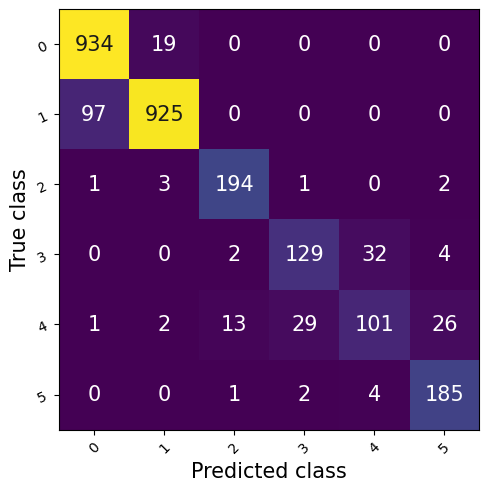

Starting Epoch 2
Train:


100%|█████████████████████████████████████████| 318/318 [36:08<00:00,  6.82s/it]


Val:


100%|███████████████████████████████████████████| 43/43 [04:26<00:00,  6.20s/it]


Training Loss: 0.2168668730641311
Training Accuracy: 0.9236766248004241
Validation Loss: 0.21599871595931608
Validation Accuracy: 0.924648103325866


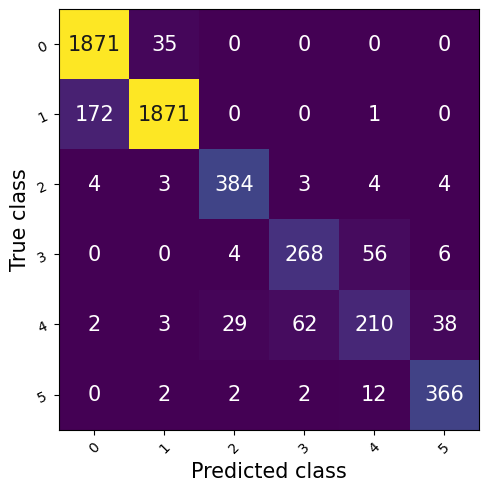

Starting Epoch 3
Train:


100%|█████████████████████████████████████████| 318/318 [36:05<00:00,  6.81s/it]


Val:


100%|███████████████████████████████████████████| 43/43 [04:41<00:00,  6.55s/it]


Training Loss: 0.18834051911560995
Training Accuracy: 0.9324063154511482
Validation Loss: 0.19214102781789247
Validation Accuracy: 0.9308254289072614


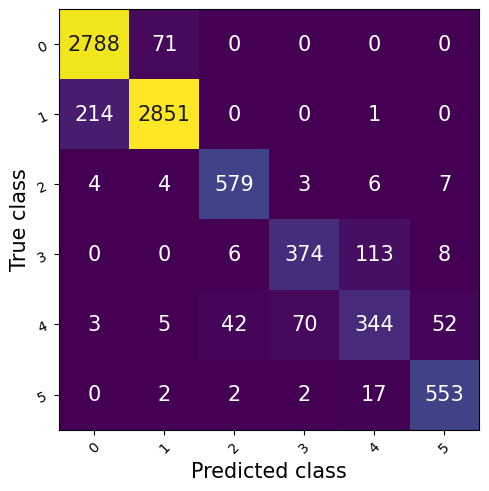

Starting Epoch 4
Train:


100%|█████████████████████████████████████████| 318/318 [36:10<00:00,  6.82s/it]


Val:


100%|███████████████████████████████████████████| 43/43 [04:27<00:00,  6.21s/it]


Training Loss: 0.16075952149599604
Training Accuracy: 0.9439203354922481
Validation Loss: 0.16414272291369217
Validation Accuracy: 0.943180080070052


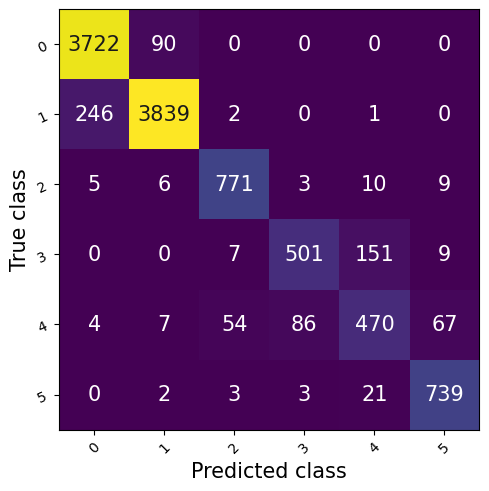

Starting Epoch 5
Train:


100%|█████████████████████████████████████████| 318/318 [37:03<00:00,  6.99s/it]


Val:


100%|███████████████████████████████████████████| 43/43 [04:25<00:00,  6.17s/it]


Training Loss: 0.14219304427223386
Training Accuracy: 0.9512578616352201
Validation Loss: 0.16563833236347797
Validation Accuracy: 0.9380928707677264


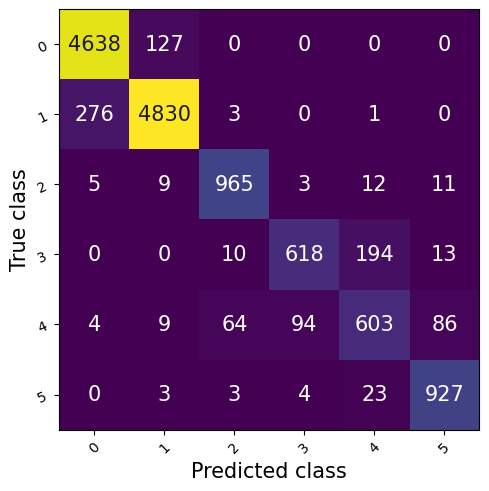

,Training Loss,Training Acc,Validation Loss,Validation Acc,Validation Jaccard,Validation F1,Validation Precision,Validation Recall
Epoch,,,,,,,,
1,0.274915,0.903056,0.250028,0.912293,tensor(0.7710),tensor(0.8614),tensor(0.8656),tensor(0.8623)
2,0.216867,0.923677,0.215999,0.924648,tensor(0.7820),tensor(0.8692),tensor(0.8722),tensor(0.8697)
3,0.188341,0.932406,0.192141,0.930825,tensor(0.7889),tensor(0.8738),tensor(0.8765),tensor(0.8731)
4,0.160760,0.943920,0.164143,0.943180,tensor(0.7970),tensor(0.8792),tensor(0.8820),tensor(0.8783)
5,0.142193,0.951258,0.165638,0.938093,tensor(0.8010),tensor(0.8821),tensor(0.8855),tensor(0.8809)


In [257]:
def train(model, epochs, optim, loss_fn, batch_size, trainloader, valloader):

    log_training = {"Epoch":[],
                    "Training Loss":[],
                    "Training Acc":[],
                    "Validation Loss":[],
                    "Validation Acc":[],
                   "Validation Jaccard":[],
                    "Validation F1":[],
                    "Validation Precision":[],
                    "Validation Recall":[]
                   }
    Jaccard = MulticlassJaccardIndex(num_classes=6)
    F1 = MulticlassF1Score(num_classes=6)
    Precision = MulticlassPrecision(num_classes=6)
    Recall = MulticlassRecall(num_classes=6)
    ConfMtx = MulticlassConfusionMatrix(num_classes=6)


    
    
    for epoch in range(1, epochs+1):
        print(f"Starting Epoch {epoch}")
        
        training_losses, training_acc =[], []
        val_losses, val_acc = [], []
        pred, target = [], []

        model.train()
        print("Train:")
        for image, label in tqdm(trainloader):
            out = model(image)

            # Compute Loss
            loss = loss_fn(out, label)
            training_losses.append(loss.item())

            # Compute Accuracy
            predictions = torch.argmax(out, axis =1)
            accuracy = (predictions == label).sum()/len(predictions)
            training_acc.append(accuracy.item())

            # Calc loss gradient and update model param
            loss.backward()
            optimizer.step()
            optimizer.zero_grad() # Zero out the gradient so it doesn't carry over
            
           

        print("Val:")
        model.eval()
        for image, label,  in tqdm(valloader):
 
            with torch.inference_mode():            
                out = model(image)

            # Compute Loss
            loss = loss_fn(out, label)
            val_losses.append(loss.item())

            # Compute Accuracy
            predictions = torch.argmax(out, axis =1)
            Jaccard.update(predictions, label)
            F1.update(predictions, label)
            Precision.update(predictions, label)
            Recall.update(predictions, label)
            ConfMtx.update(predictions, label)

           
            accuracy = (predictions == label).sum()/len(predictions)
            val_acc.append(accuracy.item())


        
        JaccardIdx = Jaccard.compute()
        F1_Score = F1.compute()
        Precision_Score = Precision.compute()
        Recall_Score = Recall.compute()
            
        training_loss_mean = np.mean(training_losses)
        val_loss_mean = np.mean(val_losses)
        
        training_acc_mean = np.mean(training_acc)
        val_acc_mean = np.mean(val_acc)

        log_training["Epoch"].append(epoch)
        log_training['Training Loss'].append(training_loss_mean)
        log_training['Training Acc'].append(training_acc_mean)
        log_training['Validation Loss'].append(val_loss_mean)
        log_training['Validation Acc'].append(val_acc_mean)
        log_training["Validation Jaccard"].append(JaccardIdx)
        log_training["Validation F1"].append(F1_Score)
        log_training["Validation Precision"].append(Precision_Score)
        log_training["Validation Recall"].append(Recall_Score)
        
        print("Training Loss:", training_loss_mean)
        print("Training Accuracy:", training_acc_mean)
        print("Validation Loss:", val_loss_mean)
        print("Validation Accuracy:", val_acc_mean)

        Eval_df = pd.DataFrame(log_training).set_index("Epoch")
        display(Eval_df.iloc[[epoch-1]])

        ConfMtx.compute()
        fig_, ax_ = ConfMtx.plot()
        plt.show()
        plt.close(fig_)
        
        
    return Eval_df, model


Eval_df, model = train(model1, epochs, optimizer, loss_fn, batch_size, MedLoader_train, MedLoader_val)
Eval_df

In [259]:
for name, param in model.named_parameters():
        param.requires_grad_(False)

In [ ]:
for name, param in model.named_parameters():
    print(name)
    print(param)

## Model Testing

* Same process as the validation loop but with a different set of data

In [284]:
def test(model, Epochs, loss_fn, batch_size, testloader):
    model.eval()
    Test_dict = {"Epoch": [], "Testing Loss":[], "Testing Accuracy":[], "Jaccard Index":[],
                 "F1 Score":[], "Precision":[], "Recall":[]}

    Jaccard = MulticlassJaccardIndex(num_classes=6)
    F1 = MulticlassF1Score(num_classes=6)
    Precision = MulticlassPrecision(num_classes=6)
    Recall = MulticlassRecall(num_classes=6)
    ConfMtx = MulticlassConfusionMatrix(num_classes=6)
    for epoch in range(1, Epochs +1):
        
        print("Starting Testing Epoch:", epoch)
        Testing_losses = []
        Testing_acc = [] 

        for image, label in tqdm(testloader):
            
            with torch.inference_mode():            
                output = model(image)
            prediction = torch.argmax(output, axis =1)
            loss = loss_fn(output, label)
            accuracy = ((prediction == label).sum())/len(prediction)
            Testing_losses.append(loss.item())
            Testing_acc.append(accuracy.item())
            Jaccard.update(prediction, label)
            F1.update(prediction, label)
            Precision.update(prediction, label)
            Recall.update(prediction, label)
            ConfMtx.update(prediction, label)

        JaccardIdx = Jaccard.compute()
        F1_Score = F1.compute()
        Precision_Score = Precision.compute()
        Recall_Score = Recall.compute()
            
        Testing_loss_mean = np.mean(Testing_losses)
        Testing_acc_mean = np.mean(Testing_acc)

        Test_dict["Epoch"].append(epoch)
        Test_dict["Testing Loss"].append(Testing_loss_mean)
        Test_dict["Testing Accuracy"].append(Testing_acc_mean)
        Test_dict["Jaccard Index"].append(JaccardIdx)
        Test_dict["F1 Score"].append(F1_Score)
        Test_dict["Precision"].append(Precision_Score)
        Test_dict["Recall"].append(Recall_Score)

        Model_Scores = pd.DataFrame(Test_dict).set_index("Epoch")
        display(Model_Scores.iloc[[epoch-1]])

        ConfMtx.compute()
        fig_, ax_ = ConfMtx.plot()
        plt.show()
        plt.close(fig_)
        

    return Model_Scores
        
        
        

        
    

Starting Testing Epoch: 1


100%|███████████████████████████████████████████| 64/64 [07:13<00:00,  6.77s/it]


,Testing Loss,Testing Accuracy,Jaccard Index,F1 Score,Precision,Recall
Epoch,,,,,,
1,0.127887,0.953788,tensor(0.8479),tensor(0.9124),tensor(0.9199),tensor(0.9112)


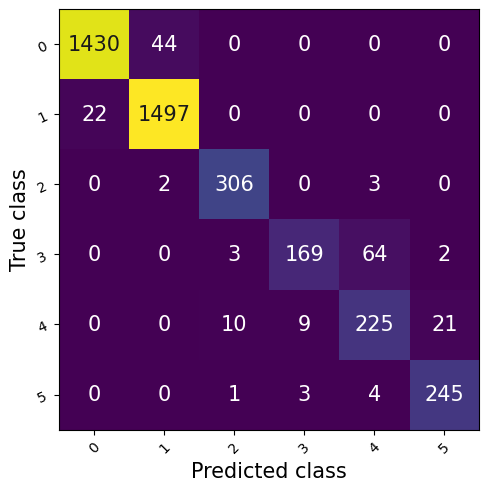

Starting Testing Epoch: 2


100%|███████████████████████████████████████████| 64/64 [07:06<00:00,  6.67s/it]


,Testing Loss,Testing Accuracy,Jaccard Index,F1 Score,Precision,Recall
Epoch,,,,,,
2,0.133984,0.952323,tensor(0.8491),tensor(0.9134),tensor(0.9214),tensor(0.9122)


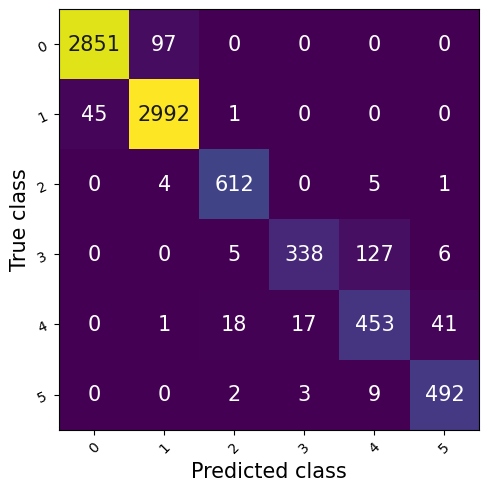

Starting Testing Epoch: 3


100%|███████████████████████████████████████████| 64/64 [07:15<00:00,  6.81s/it]


,Testing Loss,Testing Accuracy,Jaccard Index,F1 Score,Precision,Recall
Epoch,,,,,,
3,0.131819,0.953788,tensor(0.8501),tensor(0.9140),tensor(0.9219),tensor(0.9128)


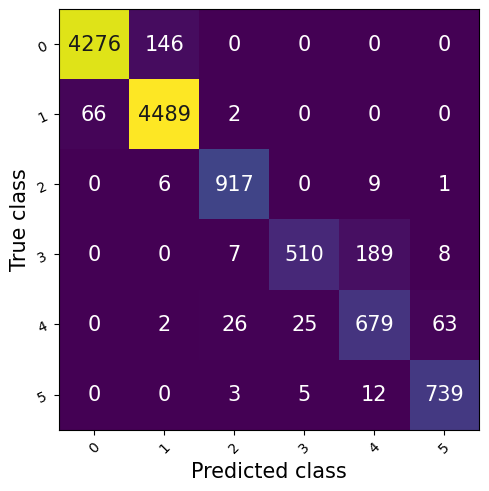

Starting Testing Epoch: 4


100%|███████████████████████████████████████████| 64/64 [07:33<00:00,  7.09s/it]


,Testing Loss,Testing Accuracy,Jaccard Index,F1 Score,Precision,Recall
Epoch,,,,,,
4,0.134527,0.950614,tensor(0.8482),tensor(0.9129),tensor(0.9207),tensor(0.9116)


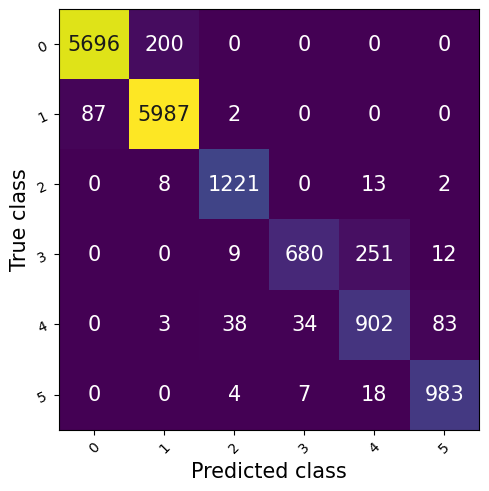

Starting Testing Epoch: 5


100%|███████████████████████████████████████████| 64/64 [07:17<00:00,  6.83s/it]


,Testing Loss,Testing Accuracy,Jaccard Index,F1 Score,Precision,Recall
Epoch,,,,,,
5,0.127668,0.952079,tensor(0.8469),tensor(0.9120),tensor(0.9197),tensor(0.9108)


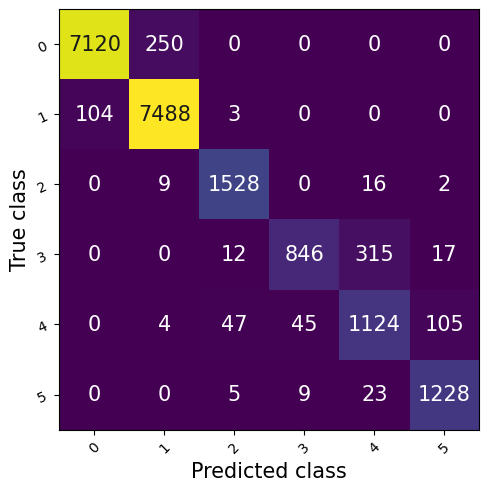

,Testing Loss,Testing Accuracy,Jaccard Index,F1 Score,Precision,Recall
Epoch,,,,,,
1,0.127887,0.953788,tensor(0.8479),tensor(0.9124),tensor(0.9199),tensor(0.9112)
2,0.133984,0.952323,tensor(0.8491),tensor(0.9134),tensor(0.9214),tensor(0.9122)
3,0.131819,0.953788,tensor(0.8501),tensor(0.9140),tensor(0.9219),tensor(0.9128)
4,0.134527,0.950614,tensor(0.8482),tensor(0.9129),tensor(0.9207),tensor(0.9116)
5,0.127668,0.952079,tensor(0.8469),tensor(0.9120),tensor(0.9197),tensor(0.9108)


In [285]:
Model_test = test(model, epochs, loss_fn, batch_size, MedLoader_test)
Model_test

In [275]:
torch.save(model.state_dict(), "MedicalClassification.pth")